In [ ]:
!pip install dataprep

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import dataprep
from dataprep import eda
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

In [ ]:
# Get the train data
trainFile = "../input/bike-sharing-demand/train.csv"
trainDataset = pd.read_csv(trainFile)
print(trainDataset.shape)
# Get the test data
testFile = "../input/bike-sharing-demand/test.csv"
testDataset = pd.read_csv(testFile)
print(testDataset.shape)

In [ ]:
trainDataset

In [ ]:
testDataset

In [ ]:
#get detailed information about columns in train dataset
eda.create_report(trainDataset, title="train data report")

In [ ]:
#show difference between train and test sets
eda.plot_diff([trainDataset, testDataset]) 

# **Data preparation** 

In [ ]:
#datetime - hourly date + timestamp  
trainDataset['Hour'] = pd.DatetimeIndex(trainDataset['datetime']).hour
trainDataset['Day'] = pd.DatetimeIndex(trainDataset['datetime']).day
trainDataset['Month'] = pd.DatetimeIndex(trainDataset['datetime']).month
trainDataset['Year'] = pd.DatetimeIndex(trainDataset['datetime']).year

testDataset['Hour'] = pd.DatetimeIndex(testDataset['datetime']).hour
testDataset['Day'] = pd.DatetimeIndex(testDataset['datetime']).day
testDataset['Month'] = pd.DatetimeIndex(testDataset['datetime']).month
testDataset['Year'] = pd.DatetimeIndex(testDataset['datetime']).year

In [ ]:
#log trainDataset to make numbers smaller
df_train_y = np.log(trainDataset['count'].values)
max(df_train_y)

In [ ]:
#drop cols 
test_data = pd.DataFrame()
test_data['datetime']=testDataset['datetime']
cols_to_drop = ['casual','registered','count','datetime','temp']
def drop_func(data,cols):
    for col in cols:
        data.drop(col, axis=1,inplace=True)
drop_func(trainDataset,cols_to_drop)

testDataset = testDataset.drop('datetime',axis=1).drop('temp', axis=1)
trainDataset

In [ ]:
# season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
# holiday - whether the day is considered a holiday
# workingday - whether the day is neither a weekend nor holiday
# weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
testDataset

# Machine learning model

In [ ]:
from sklearn.metrics import mean_squared_log_error 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#to normalize across all data
data=np.concatenate((trainDataset,testDataset)) 
print(data)

In [ ]:
sc = StandardScaler()
#scale train and test sets
data = sc.fit_transform(data)
data_test = sc.transform(testDataset)
data_train = sc.transform(trainDataset)

In [ ]:
#Split arrays or matrices into random train and test subsets
X_train, X_valid, y_train, y_valid = train_test_split(data_train, df_train_y, random_state=5, test_size = 0.2)

In [ ]:
#use gradient boosting trees algorithm
from xgboost import XGBRegressor
xg = XGBRegressor(random_state = 0, learning_rate = 0.2, n_estimators = 150)

xg.fit(X_train, y_train)
y_pred = xg.predict(X_valid)
y_train_pred = xg.predict(X_train)
#print root mean squared 
print("These are rmsle for train and validation sets {}, {}"
      .format(np.sqrt(mean_squared_log_error(np.exp(y_train_pred), np.exp(y_train))), 
              np.sqrt(mean_squared_log_error(np.exp(y_pred), np.exp(y_valid)))
             ))

In [ ]:
#get predictions for test data
predictions = np.exp(xg.predict(data_test))

In [ ]:
#form final predictions file
final_predictions = pd.DataFrame() 
final_predictions['count'] = predictions
final_predictions['datetime']=test_data['datetime']
final_predictions = final_predictions[['datetime','count']]

In [ ]:
final_predictions

In [ ]:
final_predictions.to_csv('final_submission.csv', index = False)

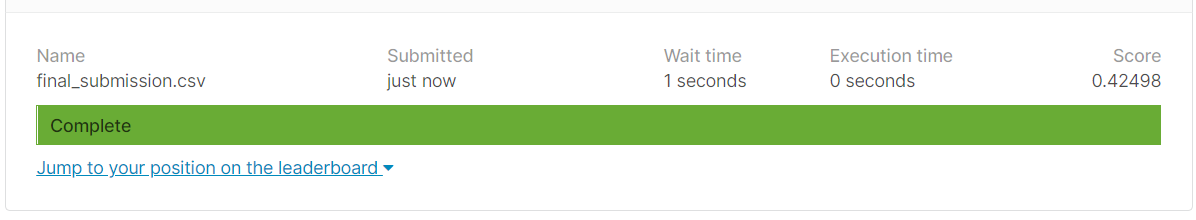

Завданням роботи було визначити кількість арендованих велосипедів щогодини в залежності від даних погоди, сезону, дня тижня та іншого. В ході виконання роботи було проаналізовано дані датасету,виявилося, що дані не мають missing values. Також з графіків видно, що найбільше з count(тобто з тим що ми прогнозуємо) корелює registred(тобто кількість зареєстрованих користувачів), зрозуміло, що ця колонка буде більше за інші впливати на результат. Також сильно корелюють колонки temp та atemp, що характеризують температуру повітря, тому одну з них було принято рішення видалити. Робота вимагає багатокласової класифікації. Для рішення задачі було вибрано XGBRegressor, в якості метрики root mean squared log error. Логарифмуємо значення щоб позбутися від'ємних значень.